In [8]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
 
import os
import pandas as pd
import numpy as np
a = [name for name in os.listdir(".") if os.path.isdir(name)]
d = pd.DataFrame()
for i in a:
    if i != '.git' or i!= 'Test':
        b = os.listdir(i)
        b = np.array(b)
        c = pd.DataFrame(b, columns=['filename'])
        c['Class'] = i
        #append to the master dataframe
        d = d.append(c)

from pathlib import Path


df = d
df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = df['Class'] + '/' + df['filename'].astype(str)
df = df.sample(frac=1)
label_encoder = preprocessing.LabelEncoder()

df['classID'] = label_encoder.fit_transform(df['Class'])

# Take relevant columns
df = df[['relative_path', 'classID','Class']]
df.head()
df.to_csv('train.csv', index=False)



In [9]:
df

,relative_path,classID,Class
229,Whoop/8MpZyLdsqkI_140.wav,16,Whoop
360,Singing/-9P-l-lKHBY_30.wav,9,Singing
334,Whispering/EWLIeAu5eHw_350.wav,15,Whispering
276,Whispering/CB6KzZxtfF8_10.wav,15,Whispering
531,Singing/-Ern_i01XsE_70.wav,9,Singing
...,...,...,...
142,Clapping/Aje_p6LSmLE_20.wav,5,Clapping
220,Whimper/14yEJ20Xnz4_30.wav,14,Whimper
126,Whoop/4gKNCxue5wo_110.wav,16,Whoop
536,Snicker/NaKZ0NuMlPU_11.wav,10,Snicker


In [10]:
df.Class.unique()

array(['Whoop', 'Singing', 'Whispering', 'Bellow', 'Clapping', 'Yell',
       'Whimper', 'Groan', 'Babbling', 'Snicker', 'shatter', 'Battle cry',
       'Children shouting', 'Screaming', 'Speech', 'Wail, moan', '.git',
       'Finger snapping', 'Test'], dtype=object)

In [11]:
df.shape

(6021, 3)

In [13]:
df= df[df['Class'] != 'Test']

In [14]:
df.shape

(6020, 3)

In [15]:
df= df[df['Class'] != '.git']

In [16]:
df.shape

(6008, 3)

In [17]:
#### Dependencies ####
#### Import Comet for experiment tracking and visual tools
from comet_ml import Experiment
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import tensorflow as tf
# from keras.optimizers import Adam
# from keras.utils import to_categorical

In [18]:
experiment = Experiment(
    api_key="TpJmHUzqkFIYdblKq8rPA9vKW",
    project_name="fyp-audio-processing",
    workspace="shakthi-stack",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shakthi-stack/fyp-audio-processing/9824c5f487184d82bcb7026262150189



In [19]:
labels = list(df['classID'].unique())

In [20]:
files = dict()
for i in range(len(labels)):
    tmp = df[df['classID'] == labels[i]][:1].reset_index()
    path = df['relative_path']
    files[labels[i]] = path

In [21]:
fn = 'Snicker/6xfMfFenKiM_70.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 16000
Librosa sample rate: 22050


In [22]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -5272 to 4727
Librosa audio file min~max range: -0.16 to -0.16


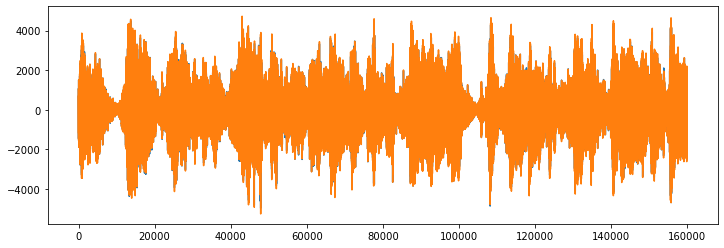

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

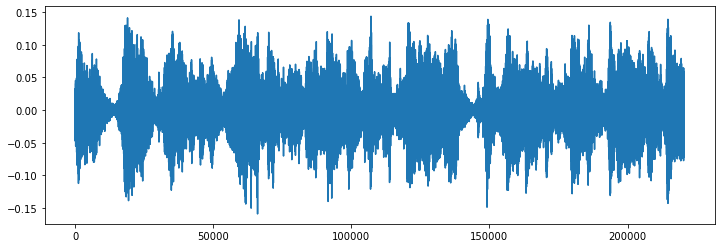

In [24]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)

In [25]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 500)

In [26]:
print(mfccs.shape)

(128, 431)


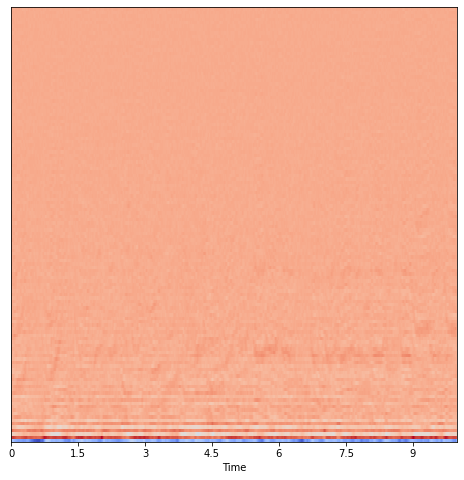

In [27]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [28]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=100)
    mfccs_processed = np.mean(mfccs.T,axis=0) 
    return mfccs_processed

In [29]:
features = []
# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    file_name = row['relative_path']
    # os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"])) 
    class_label = row["Class"]
    try:
        data = extract_features(file_name)
        features.append([data, class_label])
    except:
        print("error")
        continue
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

error


In [30]:
featuresdf

,feature,class_label
0,"[18.380108, 185.86597, -96.63032, 32.434044, -...",Whoop
1,"[-109.06404, 114.34226, -86.962425, 53.32334, ...",Singing
2,"[-565.18066, 103.22018, -46.745872, 49.919834,...",Whispering
3,"[-543.09717, 73.75494, -42.5127, 35.056156, -3...",Whispering
4,"[-103.056335, 126.53814, -91.82321, 50.263523,...",Singing
...,...,...
6002,"[-290.68225, 128.7305, -32.56096, 38.230885, -...",Clapping
6003,"[-199.50168, 138.0486, -79.58454, -8.708781, -...",Whimper
6004,"[-93.03112, 199.97882, -104.14095, 50.838604, ...",Whoop
6005,"[-275.53372, 37.868053, -76.24197, 11.037546, ...",Snicker


In [31]:
featuresdf.iloc[0]['feature']

array([ 1.83801079e+01,  1.85865967e+02, -9.66303177e+01,  3.24340439e+01,
       -3.98124733e+01,  7.57264185e+00,  4.19526196e+00, -2.54365611e+00,
        8.33585739e+00, -9.51066494e+00,  2.68738723e+00, -1.38104877e+01,
        5.90992391e-01, -2.00711441e+00,  1.94995567e-01,  1.65751541e+00,
       -2.29566646e+00,  4.11173916e+00, -3.34104276e+00,  4.09429216e+00,
        2.76140261e+00, -4.28457201e-01, -2.30285597e+00, -7.35797763e-01,
       -9.30783927e-01, -2.18988895e+00,  5.51330149e-01, -3.66048789e+00,
        6.23934008e-02, -2.18381047e+00, -3.08709598e+00,  7.38730073e-01,
        1.66319072e+00,  9.72149432e-01, -2.34328628e-01,  3.76817107e-01,
       -1.52975595e+00, -1.05040014e-01, -2.81858861e-01, -7.99201131e-01,
       -3.76416016e+00, -3.98795700e+00, -8.18907678e-01, -1.61084127e+00,
       -1.62593579e+00, -2.47970271e+00, -1.10101819e+00, -1.08765495e+00,
       -7.91558862e-01, -2.62699556e+00, -4.04344893e+00, -1.40074527e+00,
       -1.37466311e+00,  

In [32]:
from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [33]:
X.shape

(6007, 100)

In [34]:
y

array(['Whoop', 'Singing', 'Whispering', ..., 'Whoop', 'Snicker',
       'Whimper'], dtype='<U17')

In [35]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [36]:
num_labels = yy.shape[1]
filter_size = 2
def build_model_graph(input_shape=(100,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy','AUC'], optimizer='adam')
    return model
model = build_model_graph()

In [37]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


151/151 [==============================] - 2s 6ms/step - loss: 12.8173 - accuracy: 0.1444 - auc: 0.5936 - val_loss: 2.7786 - val_accuracy: 0.2529 - val_auc: 0.7062
Epoch 2/100
151/151 [==============================] - 1s 4ms/step - loss: 2.9652 - accuracy: 0.1867 - auc: 0.6645 - val_loss: 2.4659 - val_accuracy: 0.2654 - val_auc: 0.7772
Epoch 3/100
151/151 [==============================] - 1s 4ms/step - loss: 2.6563 - accuracy: 0.2183 - auc: 0.7165 - val_loss: 2.3570 - val_accuracy: 0.2937 - val_auc: 0.8100
Epoch 4/100
151/151 [==============================] - 1s 4ms/step - loss: 2.4984 - accuracy: 0.2433 - auc: 0.7535 - val_loss: 2.2678 - val_accuracy: 0.2945 - val_auc: 0.8196
Epoch 5/100
151/151 [==============================] - 1s 4ms/step - loss: 2.4293 - accuracy: 0.2685 - auc: 0.7718 - val_loss: 2.2416 - val_accuracy: 0.2953 - val_auc: 0.8264
Epoch 6/100
151/151 [==============================] - 1s 4ms/step - loss: 2.3667 - accuracy: 0.2753 - auc: 0.7856 - val_loss: 2.1766 - 

In [55]:
output = model.predict(x_test)

In [57]:
output[1]

array([0.08845344, 0.00384868, 0.00830796, 0.0175414 , 0.06515086,
       0.00085344, 0.0548446 , 0.09785555, 0.03367712, 0.1482468 ,
       0.05109857, 0.01820142, 0.33063814, 0.01486018, 0.04353921,
       0.01412572, 0.00875685], dtype=float32)

In [38]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 52.90%
Testing Accuracy: 40.77%


In [39]:
fn = 'Test/dv_test_1-[AudioTrimmer.com].wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


In [89]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -10497 to 10629
Librosa audio file min~max range: -0.25 to -0.25


In [40]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 100)

In [41]:
mfccs.shape

(100, 3116)

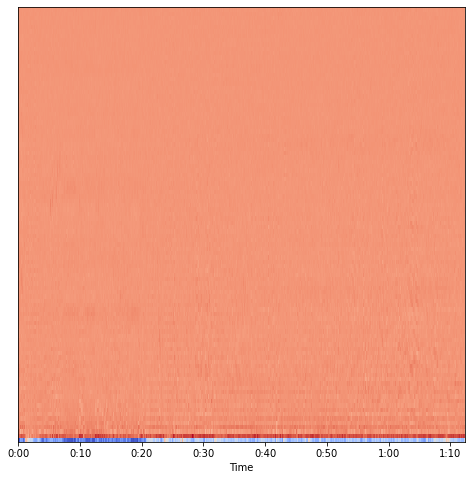

In [42]:
import librosa.display
plt.figure(figsize=(8,8))

librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [43]:
mfccs_processed = np.mean(mfccs.T,axis=0)

In [44]:
mfccs_processed

array([-3.5428116e+02,  1.0043304e+02,  3.7815650e+00,  2.6591024e+01,
        6.7473307e+00,  1.4398628e+01, -1.6803311e+00,  7.8047161e+00,
        4.6000943e-01,  4.8551879e+00, -1.0996917e-01,  5.8239813e+00,
        3.5230878e-01,  4.6289320e+00,  3.9206704e-01,  3.4700875e+00,
        9.3890035e-01,  3.1523869e+00, -6.1137092e-01,  1.5630028e+00,
       -4.3711066e-01,  2.2856452e+00, -7.5055462e-01, -2.0804171e-01,
       -2.1168647e+00,  5.1132917e-01, -1.8325610e+00,  6.3369405e-01,
       -9.0112585e-01,  1.1527293e+00, -5.2314895e-01,  1.4939402e+00,
       -3.3133012e-01,  6.8298340e-01, -1.4745341e-01,  1.3305136e+00,
       -9.0843037e-02,  8.3173327e-03, -2.0241816e+00, -1.1658217e+00,
       -1.1992157e+00,  3.3290023e-01, -1.6634411e+00, -1.0936072e+00,
       -1.7619939e+00, -2.2057742e-01, -1.0082159e+00, -3.4676087e-01,
       -1.8426174e+00, -1.3083518e+00, -1.9708797e+00, -1.0640537e+00,
       -2.0740361e+00, -1.6954092e+00, -2.3442700e+00, -9.5806080e-01,
      

In [45]:
X = np.array(mfccs_processed.tolist())

In [46]:
X.shape

(100,)

In [47]:
X

array([-3.54281158e+02,  1.00433037e+02,  3.78156495e+00,  2.65910244e+01,
        6.74733067e+00,  1.43986282e+01, -1.68033111e+00,  7.80471611e+00,
        4.60009426e-01,  4.85518789e+00, -1.09969169e-01,  5.82398129e+00,
        3.52308780e-01,  4.62893200e+00,  3.92067045e-01,  3.47008753e+00,
        9.38900352e-01,  3.15238690e+00, -6.11370921e-01,  1.56300282e+00,
       -4.37110662e-01,  2.28564525e+00, -7.50554621e-01, -2.08041713e-01,
       -2.11686468e+00,  5.11329174e-01, -1.83256102e+00,  6.33694053e-01,
       -9.01125848e-01,  1.15272927e+00, -5.23148954e-01,  1.49394023e+00,
       -3.31330121e-01,  6.82983398e-01, -1.47453412e-01,  1.33051360e+00,
       -9.08430368e-02,  8.31733271e-03, -2.02418160e+00, -1.16582167e+00,
       -1.19921565e+00,  3.32900226e-01, -1.66344106e+00, -1.09360719e+00,
       -1.76199389e+00, -2.20577419e-01, -1.00821590e+00, -3.46760869e-01,
       -1.84261739e+00, -1.30835176e+00, -1.97087967e+00, -1.06405365e+00,
       -2.07403612e+00, -

In [48]:
x=np.reshape(X,(-1,100))

In [49]:
x.shape

(1, 100)

In [50]:
x

array([[-3.54281158e+02,  1.00433037e+02,  3.78156495e+00,
         2.65910244e+01,  6.74733067e+00,  1.43986282e+01,
        -1.68033111e+00,  7.80471611e+00,  4.60009426e-01,
         4.85518789e+00, -1.09969169e-01,  5.82398129e+00,
         3.52308780e-01,  4.62893200e+00,  3.92067045e-01,
         3.47008753e+00,  9.38900352e-01,  3.15238690e+00,
        -6.11370921e-01,  1.56300282e+00, -4.37110662e-01,
         2.28564525e+00, -7.50554621e-01, -2.08041713e-01,
        -2.11686468e+00,  5.11329174e-01, -1.83256102e+00,
         6.33694053e-01, -9.01125848e-01,  1.15272927e+00,
        -5.23148954e-01,  1.49394023e+00, -3.31330121e-01,
         6.82983398e-01, -1.47453412e-01,  1.33051360e+00,
        -9.08430368e-02,  8.31733271e-03, -2.02418160e+00,
        -1.16582167e+00, -1.19921565e+00,  3.32900226e-01,
        -1.66344106e+00, -1.09360719e+00, -1.76199389e+00,
        -2.20577419e-01, -1.00821590e+00, -3.46760869e-01,
        -1.84261739e+00, -1.30835176e+00, -1.97087967e+0

In [51]:
output = model.predict(x)

In [52]:
output

array([[5.8159418e-02, 2.4637325e-06, 1.7200956e-03, 2.5624240e-06,
        5.6030229e-03, 1.3199076e-02, 4.5299944e-02, 8.6342795e-03,
        3.8266655e-03, 7.6947911e-03, 7.5928971e-02, 5.4219807e-03,
        2.9045790e-01, 4.1416764e-01, 3.0706262e-03, 1.2327561e-03,
        6.5577783e-02]], dtype=float32)

In [53]:
output.max()

0.41416764

In [54]:
output.sort()

In [140]:
output

array([[1.19991004e-04, 4.44400532e-04, 3.56548210e-03, 1.01919780e-02,
        1.03176776e-02, 1.26238931e-02, 1.51443928e-02, 2.06273422e-02,
        2.32725572e-02, 3.81582454e-02, 5.16325012e-02, 5.28725274e-02,
        5.76698445e-02, 7.19454512e-02, 9.82856378e-02, 1.11439332e-01,
        1.31898493e-01, 2.89790273e-01]], dtype=float32)